# Choice Model Calibration Analysis

This notebook analyzes how the intercept parameter in the choice model affects trip acceptance rates for the NYC Manhattan scenario at hour 19.

## 1. Import Libraries

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import networkx as nx

# Set plot style for professional appearance
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

## 2. Define Choice Model Parameters

These are the fixed parameters from the codebase (`src/envs/amod_env_multi.py`).

In [ ]:
# Fixed choice model parameters from the code
TRAVEL_TIME_COEF = 0.71  # Coefficient for travel time
WAGE = 21.40  # Hourly wage in dollars
INCOME_EFFECT = WAGE / WAGE  # Income effect multiplier
CHOICE_PRICE_MULT = 1.0  # Default price multiplier
U_REJECT = 0  # Utility of rejecting the trip (outside option)

print("Choice Model Parameters:")
print(f"  Travel time coefficient: {TRAVEL_TIME_COEF}")
print(f"  Wage: ${WAGE}/hour")
print(f"  Income effect: {INCOME_EFFECT}")
print(f"  Price multiplier: {CHOICE_PRICE_MULT}")
print(f"  Rejection utility: {U_REJECT}")

Choice Model Parameters:
  Travel time coefficient: 0.71
  Wage: $26.99/hour
  Income effect: 1.0
  Price multiplier: 1.0
  Rejection utility: 0


## 3. Generate Demand for Simulation

In [20]:
import sys
sys.path.append('/work3/s233791/rl-pricing-amod')
from src.envs.amod_env_multi import Scenario

# Create a Scenario object with the JSON file
scenario = Scenario(
    json_file="data/scenario_washington_dc.json",
    json_hr=19,  # Hour 19
    json_tstep=3,  # 3-minute time steps
    tf=20,
    impute = 0,
    demand_ratio=8.4,
    supply_ratio=1.0,
    fix_price=True
)

# Now call get_random_demand on the scenario object
trial_data = scenario.get_random_demand(reset=False)

In [21]:
trial_data

[(0, 1, 0, 1, 12.699999999999998),
 (0, 2, 0, 4, 15.8),
 (0, 3, 0, 3, 10.4),
 (0, 4, 0, 16, 9.299999999999999),
 (0, 5, 0, 19, 12.1),
 (0, 6, 0, 1, 18.8),
 (0, 7, 0, 17, 14.9),
 (0, 8, 0, 3, 12.599999999999998),
 (0, 9, 0, 1, 10.7),
 (0, 10, 0, 8, 16.2),
 (0, 11, 0, 0, 19.9),
 (0, 12, 0, 0, 14.399999999999999),
 (0, 13, 0, 2, 22.599999999999998),
 (0, 14, 0, 0, 17.299999999999997),
 (0, 15, 0, 0, 0),
 (0, 16, 0, 1, 24.899999999999995),
 (0, 17, 0, 0, 0),
 (0, 0, 0, 0, 0),
 (1, 0, 0, 0, 11.4),
 (1, 2, 0, 0, 0),
 (1, 3, 0, 0, 0),
 (1, 4, 0, 1, 14.9),
 (1, 5, 0, 3, 11.899999999999999),
 (1, 6, 0, 1, 9.4),
 (1, 7, 0, 1, 12.000000000000002),
 (1, 8, 0, 0, 0),
 (1, 9, 0, 0, 0),
 (1, 10, 0, 2, 9.0),
 (1, 11, 0, 0, 10.2),
 (1, 12, 0, 0, 0),
 (1, 13, 0, 1, 12.199999999999998),
 (1, 14, 0, 0, 0),
 (1, 15, 0, 0, 0),
 (1, 16, 0, 0, 0),
 (1, 17, 0, 0, 0),
 (1, 1, 0, 0, 0),
 (2, 0, 0, 0, 0),
 (2, 1, 0, 1, 7.199999999999999),
 (2, 3, 0, 0, 12.000000000000002),
 (2, 4, 0, 0, 11.4),
 (2, 5, 0, 0, 11.69

## 5. Analyze Trip Acceptance Across Intercept Values

## 6. Create Professional Visualization

In [22]:
# Define range of intercept values to test
intercept_range = np.linspace(6, 20, 100)

print("Two-agent Monte Carlo choice model simulation WITH POISSON SAMPLING")
print(f"Testing {len(intercept_range)} intercept values from {intercept_range[0]} to {intercept_range[-1]}")

# Run simulations
n_simulations = 50
proportion_accepted = []
accepted_demand_values = []
total_demand_values = []

for intercept in tqdm(intercept_range, desc="Testing intercept values"):
    accepted_counts = []
    total_counts = []
    
    # Run multiple Monte Carlo simulations
    for sim in range(n_simulations):
        total_accepted = 0
        total_demand = 0
        
        # Get a new random demand sample (Poisson sampling happens inside)
        trip_data = scenario.get_random_demand(reset=False)
        
        # trip_data is a list of tuples: (origin, destination, time_idx, demand, price)
        for origin, destination, time_idx, demand, price in trip_data:
            # demand is already an integer sampled from Poisson
            total_demand += demand
            
            # Get travel time for this O-D pair
            travel_time = scenario.demandTime[origin, destination][time_idx]
            travel_time_hours = travel_time / 60
            
            # Calculate utilities for both agents (same price for both in baseline)
            U_agent = intercept - TRAVEL_TIME_COEF * WAGE * travel_time_hours - INCOME_EFFECT * CHOICE_PRICE_MULT * price
            
            # Multinomial logit probabilities: agent0, agent1, reject
            exp_u_agent = np.exp(U_agent)
            exp_u_reject = np.exp(U_REJECT)
            sum_exp = 2 * exp_u_agent + exp_u_reject  # Both agents have same utility
            
            prob_accept = 2 * exp_u_agent / sum_exp  # Probability of acceptance by either agent
            
            # Sample each passenger
            for _ in range(int(demand)):
                if np.random.random() < prob_accept:
                    total_accepted += 1
        
        accepted_counts.append(total_accepted)
        total_counts.append(total_demand)
    
    # Store results
    mean_accepted = np.mean(accepted_counts)
    mean_total = np.mean(total_counts)
    proportion_accepted.append(mean_accepted / mean_total if mean_total > 0 else 0)
    accepted_demand_values.append(mean_accepted)
    total_demand_values.append(mean_total)

# Convert to arrays
intercept_range = np.array(intercept_range)
proportion_accepted = np.array(proportion_accepted)

# Find key values
idx_50 = np.argmin(np.abs(proportion_accepted - 0.5))

print(f"\nResults (averaged over {n_simulations} Poisson samples):")
print(f"  Mean total demand per simulation: {np.mean(total_demand_values):.1f} trips")
print(f"  At intercept={intercept_range[0]:.2f}: {proportion_accepted[0]:.2%}")
print(f"  At intercept={intercept_range[idx_50]:.2f} (50% acceptance): {proportion_accepted[idx_50]:.2%}")
print(f"  At intercept={intercept_range[-1]:.2f}: {proportion_accepted[-1]:.2%}")

Two-agent Monte Carlo choice model simulation WITH POISSON SAMPLING
Testing 100 intercept values from 6.0 to 20.0


Testing intercept values: 100%|██████████| 100/100 [07:50<00:00,  4.70s/it]


Results (averaged over 50 Poisson samples):
  Mean total demand per simulation: 16892.4 trips
  At intercept=6.00: 3.08%
  At intercept=11.80 (50% acceptance): 49.92%
  At intercept=20.00: 94.43%


## 7. Summary Statistics

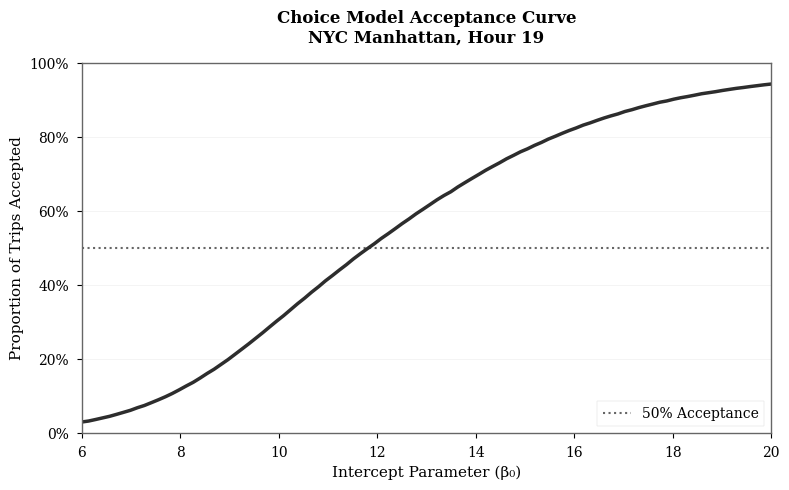


Figure saved to:
hoice_model_acceptance_curve.png
choice_model_acceptance_curve.pdf


In [23]:
# Create figure
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the main S-curve in gray tones
ax.plot(intercept_range, proportion_accepted, 
        color='#2d2d2d', linewidth=2.5)

# Add horizontal line at 50% acceptance
ax.axhline(y=0.5, color='#666666', linestyle=':', 
           linewidth=1.5, label='50% Acceptance', zorder=1)

# Add horizontal gridlines
ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5, color='#cccccc')
ax.set_axisbelow(True)

# Labels and title
ax.set_xlabel('Intercept Parameter (β₀)', fontsize=11, fontweight='normal')
ax.set_ylabel('Proportion of Trips Accepted', fontsize=11, fontweight='normal')
ax.set_title('Choice Model Acceptance Curve\nNYC Manhattan, Hour 19', 
             fontsize=12, fontweight='bold', pad=15)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Set axis limits
ax.set_xlim(intercept_range[0], intercept_range[-1])
ax.set_ylim(0, 1.0)

# Add legend
ax.legend(loc='lower right', frameon=True, fancybox=False, 
          shadow=False, framealpha=0.95, edgecolor='#cccccc')

# Adjust spine colors
for spine in ax.spines.values():
    spine.set_edgecolor('#666666')
    spine.set_linewidth(1)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig('choice_model_acceptance_curve.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('choice_model_acceptance_curve.pdf', 
            bbox_inches='tight', facecolor='white')

plt.show()

print("\nFigure saved to:")
print("hoice_model_acceptance_curve.png")
print("choice_model_acceptance_curve.pdf")

## 9. Single-Agent Choice Model Analysis

Now we analyze the same scenario with a **single-agent** choice model to compare how rejection rates differ when there's only one agent competing.

In [ ]:
# Single-agent Monte Carlo choice model simulation WITH POISSON SAMPLING
print("Single-agent Monte Carlo choice model simulation WITH POISSON SAMPLING")
print(f"Testing {len(intercept_range)} intercept values from {intercept_range[0]} to {intercept_range[-1]}")

# Run simulations
n_simulations = 50
proportion_accepted_single = []
accepted_demand_values_single = []
total_demand_values_single = []

for intercept in tqdm(intercept_range, desc="Testing intercept values (single agent)"):
    accepted_counts = []
    total_counts = []
    
    # Run multiple Monte Carlo simulations
    for sim in range(n_simulations):
        total_accepted = 0
        total_demand = 0
        
        # Get a new random demand sample (Poisson sampling happens inside)
        trip_data = scenario.get_random_demand(reset=False)
        
        # trip_data is a list of tuples: (origin, destination, time_idx, demand, price)
        for origin, destination, time_idx, demand, price in trip_data:
            # demand is already an integer sampled from Poisson
            total_demand += demand
            
            # Get travel time for this O-D pair
            travel_time = scenario.demandTime[origin, destination][time_idx]
            travel_time_hours = travel_time / 60
            
            # Calculate utilities for single agent
            U_agent = intercept - TRAVEL_TIME_COEF * WAGE * travel_time_hours - INCOME_EFFECT * CHOICE_PRICE_MULT * price
            
            # Multinomial logit probabilities: agent, reject
            exp_u_agent = np.exp(U_agent)
            exp_u_reject = np.exp(U_REJECT)
            sum_exp = exp_u_agent + exp_u_reject  # Only one agent
            
            prob_accept = exp_u_agent / sum_exp  # Probability of acceptance by the single agent
            
            # Sample each passenger
            for _ in range(int(demand)):
                if np.random.random() < prob_accept:
                    total_accepted += 1
        
        accepted_counts.append(total_accepted)
        total_counts.append(total_demand)
    
    # Store results
    mean_accepted = np.mean(accepted_counts)
    mean_total = np.mean(total_counts)
    proportion_accepted_single.append(mean_accepted / mean_total if mean_total > 0 else 0)
    accepted_demand_values_single.append(mean_accepted)
    total_demand_values_single.append(mean_total)

# Convert to arrays
proportion_accepted_single = np.array(proportion_accepted_single)

# Find key values
idx_50_single = np.argmin(np.abs(proportion_accepted_single - 0.5))

print(f"\nResults (Single Agent, averaged over {n_simulations} Poisson samples):")
print(f"  Mean total demand per simulation: {np.mean(total_demand_values_single):.1f} trips")
print(f"  At intercept={intercept_range[0]:.2f}: {proportion_accepted_single[0]:.2%}")
print(f"  At intercept={intercept_range[idx_50_single]:.2f} (50% acceptance): {proportion_accepted_single[idx_50_single]:.2%}")
print(f"  At intercept={intercept_range[-1]:.2f}: {proportion_accepted_single[-1]:.2%}")

Single-agent Monte Carlo choice model simulation WITH POISSON SAMPLING
Testing 100 intercept values from 6.0 to 20.0


Testing intercept values (single agent):  12%|█▏        | 12/100 [00:55<06:43,  4.59s/it]

## 10. Compare Single-Agent vs Two-Agent Models

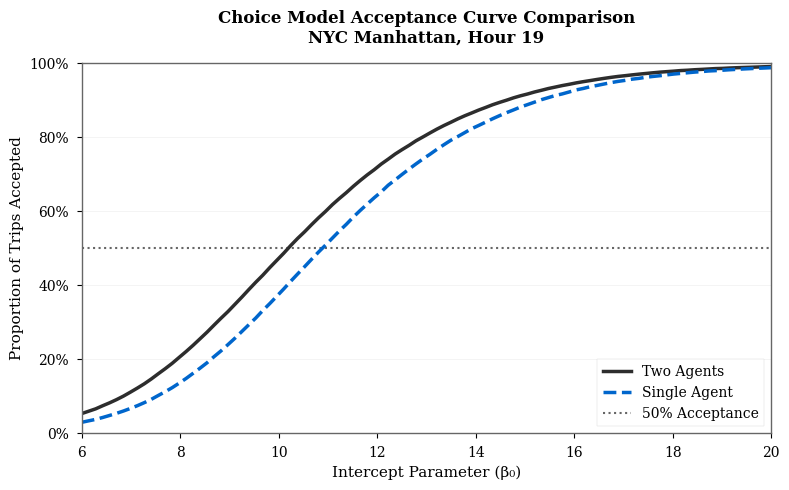


Figure saved to:
  - choice_model_comparison_1vs2_agents.png
  - choice_model_comparison_1vs2_agents.pdf


In [ ]:
# Create comparison figure
fig, ax = plt.subplots(figsize=(8, 5))

# Plot both curves
ax.plot(intercept_range, proportion_accepted, 
        color='#2d2d2d', linewidth=2.5, label='Two Agents')
ax.plot(intercept_range, proportion_accepted_single, 
        color='#0066cc', linewidth=2.5, linestyle='--', label='Single Agent')

# Add horizontal line at 50% acceptance
ax.axhline(y=0.5, color='#666666', linestyle=':', 
           linewidth=1.5, label='50% Acceptance', zorder=1)

# Add horizontal gridlines
ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5, color='#cccccc')
ax.set_axisbelow(True)

# Labels and title
ax.set_xlabel('Intercept Parameter (β₀)', fontsize=11, fontweight='normal')
ax.set_ylabel('Proportion of Trips Accepted', fontsize=11, fontweight='normal')
ax.set_title('Choice Model Acceptance Curve Comparison\nNYC Manhattan, Hour 19', 
             fontsize=12, fontweight='bold', pad=15)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Set axis limits
ax.set_xlim(intercept_range[0], intercept_range[-1])
ax.set_ylim(0, 1.0)

# Add legend
ax.legend(loc='lower right', frameon=True, fancybox=False, 
          shadow=False, framealpha=0.95, edgecolor='#cccccc')

# Adjust spine colors
for spine in ax.spines.values():
    spine.set_edgecolor('#666666')
    spine.set_linewidth(1)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig('choice_model_comparison_1vs2_agents.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('choice_model_comparison_1vs2_agents.pdf', 
            bbox_inches='tight', facecolor='white')

plt.show()

print("\nFigure saved to:")
print("  - choice_model_comparison_1vs2_agents.png")
print("  - choice_model_comparison_1vs2_agents.pdf")

In [ ]:
# Create comparison summary dataframe
comparison_df = pd.DataFrame({
    'Intercept': intercept_range,
    'Two_Agent_Acceptance': proportion_accepted,
    'Single_Agent_Acceptance': proportion_accepted_single,
    'Difference': proportion_accepted - proportion_accepted_single
})

# Find key intercept values for single agent
idx_10_single = np.argmin(np.abs(proportion_accepted_single - 0.1))
idx_25_single = np.argmin(np.abs(proportion_accepted_single - 0.25))
idx_50_single = np.argmin(np.abs(proportion_accepted_single - 0.5))
idx_75_single = np.argmin(np.abs(proportion_accepted_single - 0.75))
idx_90_single = np.argmin(np.abs(proportion_accepted_single - 0.9))

print("=" * 80)
print("COMPARISON: SINGLE-AGENT vs TWO-AGENT MODELS")
print("=" * 80)
print(f"\nIntercept values for target acceptance rates:")
print(f"\n{'Target':<15} {'Two-Agent β₀':<15} {'Single-Agent β₀':<20} {'Difference':<10}")
print("-" * 80)
print(f"{'10% acceptance':<15} {intercept_range[idx_10]:<15.2f} {intercept_range[idx_10_single]:<20.2f} {intercept_range[idx_10_single]-intercept_range[idx_10]:<10.2f}")
print(f"{'25% acceptance':<15} {intercept_range[idx_25]:<15.2f} {intercept_range[idx_25_single]:<20.2f} {intercept_range[idx_25_single]-intercept_range[idx_25]:<10.2f}")
print(f"{'50% acceptance':<15} {intercept_range[idx_50]:<15.2f} {intercept_range[idx_50_single]:<20.2f} {intercept_range[idx_50_single]-intercept_range[idx_50]:<10.2f}")
print(f"{'75% acceptance':<15} {intercept_range[idx_75]:<15.2f} {intercept_range[idx_75_single]:<20.2f} {intercept_range[idx_75_single]-intercept_range[idx_75]:<10.2f}")
print(f"{'90% acceptance':<15} {intercept_range[idx_90]:<15.2f} {intercept_range[idx_90_single]:<20.2f} {intercept_range[idx_90_single]-intercept_range[idx_90]:<10.2f}")
print("=" * 80)
print("\nKey insight: Single-agent model requires HIGHER intercept to achieve same acceptance rate")
print("because there's only one agent available instead of two competing agents.")

# Display sample comparison
print("\nSample comparison (every 20th value):")
display(comparison_df.iloc[::20].round(3))

COMPARISON: SINGLE-AGENT vs TWO-AGENT MODELS

Intercept values for target acceptance rates:

Target          Two-Agent β₀    Single-Agent β₀      Difference
--------------------------------------------------------------------------------
10% acceptance  6.85            7.56                 0.71      
25% acceptance  8.40            9.11                 0.71      
50% acceptance  10.24           10.95                0.71      
75% acceptance  12.36           13.07                0.71      
90% acceptance  14.63           15.33                0.71      

Key insight: Single-agent model requires HIGHER intercept to achieve same acceptance rate
because there's only one agent available instead of two competing agents.

Sample comparison (every 20th value):


,Intercept,Two_Agent_Acceptance,Single_Agent_Acceptance,Difference
0,6.000,0.054,0.030,0.024
20,8.828,0.311,0.223,0.088
40,11.657,0.684,0.603,0.081
60,14.485,0.895,0.859,0.036
80,17.313,0.971,0.960,0.011
